In [5]:
import sys

sys.path.append("/Users/leo/Desktop/Thesis/utils/")
sys.path.append("/Users/leo/Desktop/Thesis/models/")

from helper_functions import delete_ds_store, plot_metrics, test, train, set_device, mean_std_finder, load_model
from CBAM import _CBAM
from MBNV3_2 import MBNV3Creator
from config import comet_token, project_name, workspace
from image_attention_vis import VisualizeAttention

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision.models import mobilenet_v3_large, mobilenet_v3_small
from torchvision.models import MobileNet_V3_Large_Weights as weights_large, MobileNet_V3_Small_Weights as weights_small
import torchvision.transforms as transforms
from torchinfo import summary

import torchvision.transforms as transforms
from pytorch_grad_cam import GradCAM

#setting the seed for reproducibility
torch.manual_seed(42)

In [6]:
prms = {
    "backbone": mobilenet_v3_small,
    "weights": None,
    "module": _CBAM,
    "module_alias": "CBAM",
    "data_path": "../data/faces_50/",
    "batch_size": 16,
    "img_size": 224,
    "num_classes": 50,
    "epochs": 7,
    "learning_rate": 0.001,
    "device": set_device(),
    "model": None,
    "experiment": None,
    "load_model": True,
}
prms["model_save_path"] = f"./output/{prms['module_alias']}_{prms['data_path'].split('/')[-2]}.pth"

model = prms["model"] = MBNV3Creator(prms["backbone"], prms["num_classes"], prms["weights"], prms["device"], prms["module"])
delete_ds_store(prms["data_path"])

In [7]:
#mean, std = mean_std_finder(prms["data_path"])
mean, std = torch.tensor([0.3860, 0.3119, 0.2690]), torch.tensor([0.2279, 0.2167, 0.2135])

train_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [9]:
#Accessing the data
train_data = torchvision.datasets.ImageFolder(prms["data_path"] + "train/", transform=train_transform)
val_data = torchvision.datasets.ImageFolder(prms["data_path"] + "val/", transform=test_transform)
test_data = torchvision.datasets.ImageFolder(prms["data_path"] + "test/", transform=test_transform)

#Creating the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False, num_workers=0)

FileNotFoundError: Found no valid file for the classes 104, 1051, 1056, 1058, 1067, 1069, 1093, 1263, 1264, 1290, 1297, 132, 135, 1403, 1432, 1435, 1600, 1607, 1631, 1638, 1852, 1855, 1864, 1890, 1899, 300, 307, 309, 336, 338, 551, 556, 560, 569, 594, 61, 66, 752, 763, 764, 790, 797, 907, 909, 92, 931, 936, 938, 95. Supported extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


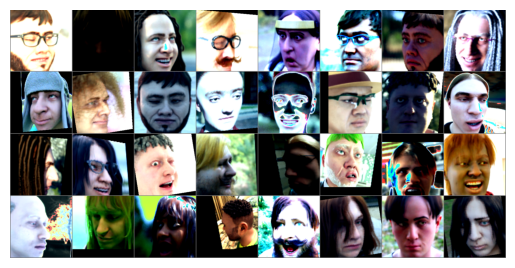

In [ ]:
#display random images from the dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #drop axis labels
    plt.axis('off')
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
#build the model
model = load_model(model.build(), prms["model_save_path"]) if prms["load_model"] else model.build()

# Loss and optimizer
criterion = nn.CrossEntropyLoss().to(prms["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=prms["learning_rate"])

# log loss and optimizer
prms["experiment"].log_parameters({"loss": criterion, "optimizer": optimizer}) if prms["experiment"] else None

SE layers: [1, 4, 5, 6, 7, 8, 9, 10, 11]
<class 'CBAM._CBAM'> inserted in the following layers: [1, 4, 5, 6, 7, 8, 9, 10, 11]
Weights initialized for <class 'CBAM._CBAM'> inserted in the following layers: [1, 4, 5, 6, 7, 8, 9, 10, 11] as well as the last layer.
Grads set to True for [1, 4, 5, 6, 7, 8, 9, 10, 11] and the last layer. (False for the rest)
Model loaded from ./output/CBAM_faces_50.pth


In [ ]:
summary(model, input_size=(1, 3, prms["img_size"], prms["img_size"]),
        col_names = ["input_size", "output_size", "num_params", "kernel_size", "mult_adds", "trainable"],
        col_width = 20,
        row_settings = ["var_names"],
        depth=8)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Kernel Shape         Mult-Adds            Trainable
MobileNetV3 (MobileNetV3)                                    [1, 3, 224, 224]     [1, 50]              --                   --                   --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 576, 7, 7]       --                   --                   --                   Partial
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 16, 112, 112]    --                   --                   --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 16, 112, 112]    (432)                [3, 3]               5,419,008            False
│    │    └─BatchNorm2d (1)                                  [1, 16, 112, 112]    [1, 16, 112, 112]    (32)                 --      

  0%|          | 0/90 [00:00<?, ?it/s]/Users/leo/Desktop/Thesis/env/lib/python3.9/site-packages/torch/nn/functional.py:2101: UserWarning: The operator 'aten::hardswish_' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  return torch._C._nn.hardswish_(input)
100%|██████████| 18/18 [00:02<00:00,  6.05it/s]


Epoch: 01 | Epoch Time: 0.0m 36s
	Train Loss: 3.657 | Train Acc: 10.04%
	 Val. Loss: 3.982 |  Val. Acc: 3.45%
Best Accuracy Achieved: 3.45% on epoch 01


100%|██████████| 18/18 [00:02<00:00,  7.17it/s]


Epoch: 02 | Epoch Time: 0.0m 32s
	Train Loss: 2.673 | Train Acc: 29.05%
	 Val. Loss: 1.656 |  Val. Acc: 52.73%
Best Accuracy Achieved: 52.73% on epoch 02


100%|██████████| 18/18 [00:02<00:00,  7.37it/s]


Epoch: 03 | Epoch Time: 0.0m 32s
	Train Loss: 1.396 | Train Acc: 60.39%
	 Val. Loss: 1.025 |  Val. Acc: 69.27%
Best Accuracy Achieved: 69.27% on epoch 03


100%|██████████| 18/18 [00:02<00:00,  7.26it/s]


Epoch: 04 | Epoch Time: 0.0m 31s
	Train Loss: 0.858 | Train Acc: 74.60%
	 Val. Loss: 0.775 |  Val. Acc: 76.55%
Best Accuracy Achieved: 76.55% on epoch 04


100%|██████████| 18/18 [00:02<00:00,  6.75it/s]


Epoch: 05 | Epoch Time: 0.0m 32s
	Train Loss: 0.602 | Train Acc: 82.46%
	 Val. Loss: 0.724 |  Val. Acc: 77.45%
Best Accuracy Achieved: 77.45% on epoch 05


100%|██████████| 18/18 [00:02<00:00,  6.80it/s]


Epoch: 06 | Epoch Time: 0.0m 33s
	Train Loss: 0.488 | Train Acc: 84.32%
	 Val. Loss: 0.516 |  Val. Acc: 84.00%
Best Accuracy Achieved: 84.00% on epoch 06


100%|██████████| 18/18 [00:02<00:00,  6.72it/s]


Epoch: 07 | Epoch Time: 0.0m 32s
	Train Loss: 0.355 | Train Acc: 89.61%
	 Val. Loss: 0.472 |  Val. Acc: 85.27%
Best Accuracy Achieved: 85.27% on epoch 07


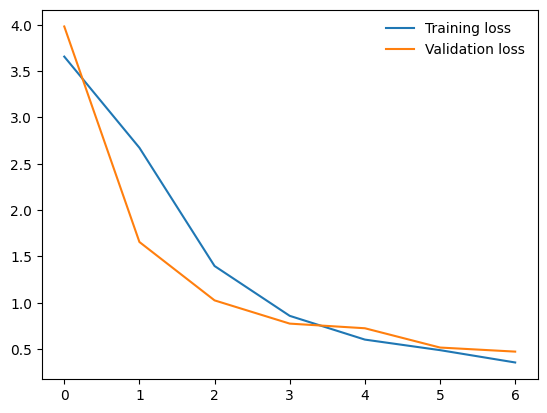

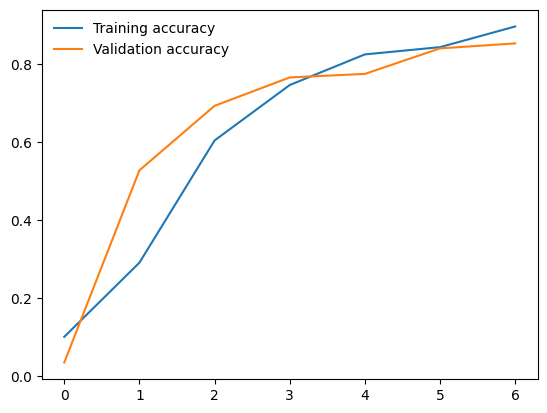

In [ ]:
#train the model
train_losses, train_acc, val_losses, val_acc = train(model, train_loader, val_loader, criterion, optimizer, hyper_params = prms, verbose = 2, experiment = prms["experiment"])

#plot the training and validation metrics
plot_metrics(train_losses, train_acc, val_losses, val_acc)

In [ ]:
#test the model
test(model, test_loader, criterion, hyper_params = prms, experiment = prms["experiment"])

Test loss: 0.406.. 
Test accuracy: 0.865
Test Time: 0.0m 1s 411ms


(0.40592881202697756, tensor(0.8650, device='mps:0'))

/Users/leo/Desktop/Thesis/env/lib/python3.9/site-packages/torch/nn/functional.py:2101: UserWarning: The operator 'aten::hardswish_' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  return torch._C._nn.hardswish_(input)


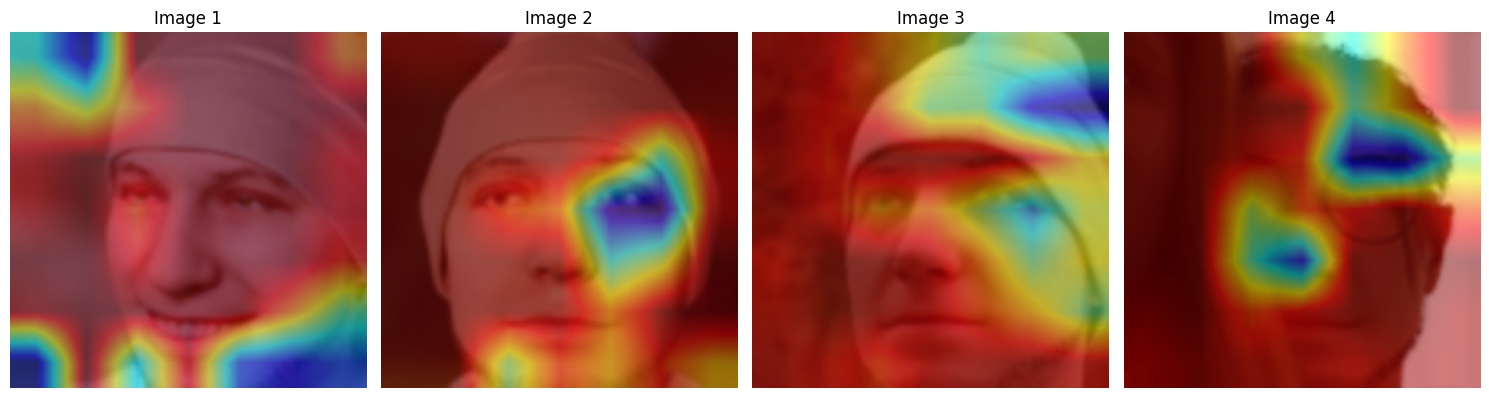

In [ ]:
visualiser = VisualizeAttention(model,"/Users/leo/Desktop/Thesis/data/faces_50/test/59", -1, prms, train_transform)

visualiser.process_images_in_folder()